## Step 1 : Set Environmnent & Load Data

In [1]:
VERSION = "0.3"

In [2]:
import sys
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from dotenv import load_dotenv

from scipy.sparse import coo_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

sys.path.append(os.path.abspath(".."))

In [3]:
### Define Data Paths

# Load .env
load_dotenv()

# Input, Output Data directories
FINE_DATA_DIR = os.getenv("FINE_DATA_DIR")
FEED_DATA_DIR = os.getenv("FEED_DATA_DIR")

# Vespa App name
VESPA_APP_NAME = os.getenv("VESPA_APP_NAME")

# Check Input Directories Existence
if not os.path.exists(FINE_DATA_DIR):
    raise FileNotFoundError(f"❌ Fine Data Directory not found: {FINE_DATA_DIR}")

# Create Output Directory if not exists
if not os.path.exists(FEED_DATA_DIR):
    os.makedirs(FEED_DATA_DIR)
    print(f"✅ Successfully create {FEED_DATA_DIR} directory.")

# Users, Products, Interactions file paths
USERS_FILE_PATH = os.path.join(FINE_DATA_DIR, "fine_users.jsonl")
PRODUCTS_FILE_PATH = os.path.join(FINE_DATA_DIR, "fine_products.jsonl")
INTERACTIONS_FILE_PATH = os.path.join(FINE_DATA_DIR, "fine_interactions.jsonl")

In [4]:
### Model & Business Logic Configuration

# Matrix Factorization Hyperparameters
VECTOR_DIMENSION = int(os.getenv("VECTOR_DIMENSION"))
N_ITER = 10
RANDOM_STATE = 100

# Data Splitter Configuration
TEST_RATIO = 0.2
MIN_INTERACTIONS = 2

# Time Decay Weight Configuration
HALF_LIFE_DAYS = 7
MIN_WEIGHT = 1.0

# Log Normalization Weight Transformer Configuration
LOG_BASE = np.e

# BM25 Weight Transformer Configuration
BM25_K1 = 1.2
BM25_B = 0.75

# Evaluation Configuration
TOP_K = 10
SAMPLE_N = 1000

# Cold Start Configuration
USER_COLD_START_TOP_N = 50
PRODUCT_COLD_START_TOP_N = 50

In [5]:
### Define JSONL Loader Function and Load Data


def load_jsonl(file_path: str) -> pd.DataFrame:
    """
    Load JSONL file into pandas DataFrame.
    """

    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        return None

    try:
        df = pd.read_json(file_path, lines=True)
        print(f"✅ [{os.path.basename(file_path)}] Loaded {len(df):,} rows.")
        return df

    except Exception as e:
        print(f"❌ Error: {e}")
        return None


df_users = load_jsonl(USERS_FILE_PATH)
df_products = load_jsonl(PRODUCTS_FILE_PATH)
df_interactions = load_jsonl(INTERACTIONS_FILE_PATH)

if any(df is None for df in [df_users, df_products, df_interactions]):
    raise RuntimeError("❌ Failed to load data files. Please check the file paths.")

✅ [fine_users.jsonl] Loaded 49,382 rows.
✅ [fine_products.jsonl] Loaded 642,009 rows.
✅ [fine_interactions.jsonl] Loaded 5,831,562 rows.


In [6]:
### Sanity check (Data Inspection)

print(f"✅ Users (Shape: {df_users.shape})")
display(df_users)

print(f"✅ Products (Shape: {df_products.shape})")
display(df_products)

print(f"✅ Interactions (Shape: {df_interactions.shape})")
display(df_interactions)

✅ Users (Shape: (49382, 4))


,uid,country,state,zipcode
0,0,United States,CA,70605
1,1,Mexico,Baja California,22460
2,2,United States,KY,40216
3,3,United States,HI,96740
4,4,United States,CA,71071
...,...,...,...,...
49377,49377,United States,OR,97355
49378,49378,Canada,BC,v0e 1m0
49379,49379,United States,PA,19143
49380,49380,Venezuela,aragua,2103


✅ Products (Shape: (642009, 3))


,pid,name,categories
0,0,TM1856,"[1, 8, 20]"
1,1,QNFSK25S65957,"[1, 14, 1541]"
2,2,VT60201K .,"[1, 8, 22]"
3,3,ICAL-02,"[1, 501, 45]"
4,4,FSD801791-STK,"[1, 13, 44]"
...,...,...,...
642004,642004,MD51274,"[1, 13, 44]"
642005,642005,IT3987-01_B,"[1, 8, 22]"
642006,642006,GY8144,"[3, 69, 172]"
642007,642007,SJE310005_3,"[900, 905]"


✅ Interactions (Shape: (5831562, 3))


,timestamp,uid,pid
0,2025-10-17 02:37:12,32068,145751
1,2025-10-17 02:37:24,30935,340990
2,2025-10-17 02:37:43,35868,360558
3,2025-10-17 02:39:11,19767,425042
4,2025-10-17 02:39:28,34589,124334
...,...,...,...
5831557,2025-11-14 23:59:58,30652,206834
5831558,2025-11-14 23:59:58,9119,87584
5831559,2025-11-14 23:59:58,11561,393571
5831560,2025-11-14 23:59:58,14661,323023


## Step 2 : Data Cleaning & Preprocessing

In [7]:
### Data Cleaning & Preprocessing

original_len_users = len(df_users)
original_len_products = len(df_products)
original_len_interactions = len(df_interactions)

# Drop rows with missing values (Nulls)
df_users.dropna(subset=["uid"], inplace=True)
df_products.dropna(subset=["pid"], inplace=True)
df_interactions.dropna(subset=["uid", "pid", "timestamp"], inplace=True)

# Standardize IDs
df_users["uid"] = df_users["uid"].astype(str).str.strip()
df_products["pid"] = df_products["pid"].astype(str).str.strip()
df_interactions["uid"] = df_interactions["uid"].astype(str).str.strip()
df_interactions["pid"] = df_interactions["pid"].astype(str).str.strip()

# Convert Timestamp (UnixTime ms -> Datetime)
df_interactions["timestamp"] = pd.to_datetime(df_interactions["timestamp"], unit="ms")

# Segmentation ID
df_users["segment_id"] = df_users["country"].fillna("UNKNOWN") + "_" + df_users["state"].fillna("UNKNOWN")
df_users["segment_id"] = df_users["segment_id"].str.upper().str.replace(" ", "_")


print(f"✅ Users : {original_len_users:,} -> {len(df_users):,} rows.")
print(f"✅ Products : {original_len_products:,} -> {len(df_products):,} rows.")
print(f"✅ Interactions : {original_len_interactions:,} -> {len(df_interactions):,} rows.")

✅ Users : 49,382 -> 49,382 rows.
✅ Products : 642,009 -> 642,009 rows.
✅ Interactions : 5,831,562 -> 5,831,562 rows.


## Step 3 : ID Mapping

In [8]:
### Create ID Mapping Dictionaries & Apply Mapping to DataFrame

# Extract unique IDs
unique_users = sorted(df_interactions["uid"].unique())
unique_products = sorted(df_interactions["pid"].unique())

# Forward Mapping : String ID -> Integer Index (Used for Model Training)
user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
product_to_idx = {product: idx for idx, product in enumerate(unique_products)}

# Reverse Mapping : Integer Index -> String ID (Used for Exporting to Vespa)
idx_to_user = {idx: user for user, idx in user_to_idx.items()}
idx_to_product = {idx: product for product, idx in product_to_idx.items()}

# Apply Mapping to DataFrame
df_interactions["user_idx"] = df_interactions["uid"].map(user_to_idx)
df_interactions["product_idx"] = df_interactions["pid"].map(product_to_idx)


print("✅ Successfully mapped IDs.")
print(f"Unique Users : {len(unique_users):,} / {len(df_users):,}")
print(f"Unique Products : {len(unique_products):,} / {len(df_products):,}")

display(df_interactions.head())

✅ Successfully mapped IDs.
Unique Users : 38,820 / 49,382
Unique Products : 539,800 / 642,009


,timestamp,uid,pid,user_idx,product_idx
0,2025-10-17 02:37:12,32068,145751,24189,50619
1,2025-10-17 02:37:24,30935,340990,22945,266668
2,2025-10-17 02:37:43,35868,360558,28344,288327
3,2025-10-17 02:39:11,19767,425042,10708,359683
4,2025-10-17 02:39:28,34589,124334,26951,26923


## Step 4 : Data Splitting (Train/Test Split)

In [9]:
### Split Train/Test Set

from modules.data_splitters import StratifiedDataSplitter

# Stratified Data Splitter
splitter = StratifiedDataSplitter(test_ratio=TEST_RATIO, min_interactions=MIN_INTERACTIONS, random_state=RANDOM_STATE)
df_train, df_test = splitter.split(df_interactions)

print()
print(f"✅ Successfully split data into Train & Test sets.")
print(f"Train Set : {len(df_train):,} interactions.")
print(f"Test Set : {len(df_test):,} interactions.")

⚙️ Splitting raw data (Test Ratio : 0.20, Min Interactions : 2)...
Eligible Users : 35,792 / 38,820
Ineligible Users : 3,028 / 38,820

✅ Successfully split data into Train & Test sets.
Train Set : 4,665,855 interactions.
Test Set : 1,165,707 interactions.


## Step 5 : Feature Engineering (Weighting & Aggregation)

- if you need to change the weighting or aggregation logic, define the new function here and apply the weights or aggregation in the next step.



✅ Successfully applied Time Decay Weights.
Reference Date : 2025-11-14 23:59:59


,timestamp,uid,pid,user_idx,product_idx,raw_weight
3550216,2025-11-04 22:47:03,33947,18301,26245,91855,0.369640
4254839,2025-11-08 00:26:56,33118,443206,25335,379790,0.500927
5203241,2025-11-12 13:10:52,27543,207033,19232,118435,0.784524
130725,2025-10-17 22:19:52,26891,204970,18516,116150,0.062071
348722,2025-10-19 13:47:07,38410,402137,31122,334345,0.073044


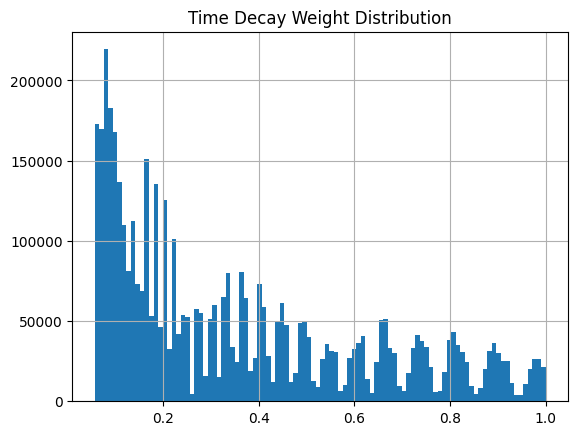

In [10]:
### Calculate Time Decay Weights

# Set Reference Date (Use the latest timestamp as the reference date)
reference_date = df_interactions["timestamp"].max()

# Calculate the difference in days between the reference date and the timestamp
diff_days = (reference_date - df_train["timestamp"]).dt.total_seconds() / (24 * 60 * 60)

# Calculate the decay lambda : ln(2) / HALF_LIFE_DAYS
decay_lambda = np.log(2) / HALF_LIFE_DAYS

# Apply weights based on the time difference
# df_train["raw_weight"] = np.where(diff_days <= THRESHOLD_DAYS, BOOSTED_WEIGHT, BASE_WEIGHT)
df_train["raw_weight"] = MIN_WEIGHT * np.exp(-decay_lambda * diff_days)

print("✅ Successfully applied Time Decay Weights.")
print(f"Reference Date : {reference_date}")

display(df_train.head())

# Plot the weight distribution
df_train["raw_weight"].hist(bins=100)
plt.title("Time Decay Weight Distribution")
plt.show()

In [11]:
### Aggregate Duplicate Interactions

from modules.weight_transformers import LogNormalizationWeightTransformer, BM25WeightTransformer

# Log Normalization Weight Transformer
# weight_transformer = LogNormalizationWeightTransformer(base=LOG_BASE)

# BM25 Weight Transformer
weight_transformer = BM25WeightTransformer(k1=BM25_K1, b=BM25_B)

# Aggregate Duplicate Interactions
df_matrix = df_train.groupby(["user_idx", "product_idx"])["raw_weight"].sum().reset_index()

print(f"Max Raw Weight : {df_matrix["raw_weight"].max()}")
display(df_matrix.head())

# Apply BM25 Transformation
df_matrix["weight"] = weight_transformer.transform(df_matrix)
# df_matrix["weight"] = df_matrix["raw_weight"]

print("✅ Successfully applied BM25 Transformation.")
print(f"Max Weight : {df_matrix["weight"].max():.4f}")
print(f"Min Weight : {df_matrix["weight"].min():.4f}")
print(f"Mean Weight : {df_matrix["weight"].mean():.4f}")
display(df_matrix.head())

Max Raw Weight : 116.1687971352162


,user_idx,product_idx,raw_weight
0,0,144,2.574759
1,0,874,0.833799
2,0,1189,0.839253
3,0,2043,0.418747
4,0,2909,0.944076


⚙️ Applying BM25 Transformation (K1 : 1.20, B : 0.75)...
✅ Successfully applied BM25 Transformation.
Max Weight : 21.4903
Min Weight : 0.0088
Mean Weight : 3.3224


,user_idx,product_idx,raw_weight,weight
0,0,144,2.574759,1.671259
1,0,874,0.833799,0.738139
2,0,1189,0.839253,0.567516
3,0,2043,0.418747,0.290277
4,0,2909,0.944076,0.560228


## Step 6 : Sparse Matrix Construction

In [12]:
### Construct Sparse Matrix (COO Format)

# Prepare Data for COO Matrix
# COO Format : (data, (row, col))
row = df_matrix["user_idx"].values
col = df_matrix["product_idx"].values
data = df_matrix["weight"].values

# Define Matrix Shape explicitly
num_users = len(user_to_idx)
num_products = len(product_to_idx)

# Create Sparse Matrix
user_product_matrix = coo_matrix((data, (row, col)), shape=(num_users, num_products), dtype=np.float32)

# Convert to CSR Format for Efficient Operations
user_product_matrix = user_product_matrix.tocsr()
print("✅ Successfully constructed Sparse Matrix.")

# Verify Matrix Properties
print(f"Type : {type(user_product_matrix)}")
print(f"Shape : {user_product_matrix.shape} (Users x Products)")
print(f"Non-Zero Elements : {user_product_matrix.nnz:,}")

# Calculate Matrix Density (Sparsity)
density = user_product_matrix.nnz / (num_users * num_products) * 100
print(f"Matrix Density : {density:.4f}%")

✅ Successfully constructed Sparse Matrix.
Type : <class 'scipy.sparse._csr.csr_matrix'>
Shape : (38820, 539800) (Users x Products)
Non-Zero Elements : 2,160,424
Matrix Density : 0.0103%


## Step 7 : Latent Factor Model Training (SVD)

In [13]:
### Train SVD Model

# For Quick Test/Debugging
# VECTOR_DIMENSION = 1

print("⚙️ Training Configuration :")
print("Algorithm : TruncatedSVD (Randomized SVD)")
print(f"Vector Dimension : {VECTOR_DIMENSION}")
print(f"Number of Iterations : {N_ITER}")
print(f"Random State : {RANDOM_STATE}")

# TruncatedSVD : Dimensionality reduction on the User-Product Sparse Matrix
svd = TruncatedSVD(n_components=VECTOR_DIMENSION, n_iter=N_ITER, random_state=RANDOM_STATE, algorithm="randomized")

print(f"\n⚙️ Fitting model to matrix of shape {user_product_matrix.shape}...")

# fit_transform() learns the model and returns the user vectors
user_factors_raw = svd.fit_transform(user_product_matrix)

# Extract the product vectors (Transposed)
product_factors_raw = svd.components_.T

# Normalize the user and product vectors to unit length
# Cosine Similarity = (A * B) / (|A| * |B|)
# Dot Product = A * B
# If Vectors are normalized to unit length, Dot Product is equal to Cosine Similarity (Vespa Angular Distance)
user_factors = normalize(user_factors_raw, axis=1, norm="l2")
product_factors = normalize(product_factors_raw, axis=1, norm="l2")

print(f"✅ Successfully trained SVD Model.")
print(f"User Vectors : {user_factors.shape} (Users x {VECTOR_DIMENSION})")
print(f"Product Vectors : {product_factors.shape} (Products x {VECTOR_DIMENSION})")

⚙️ Training Configuration :
Algorithm : TruncatedSVD (Randomized SVD)
Vector Dimension : 256
Number of Iterations : 10
Random State : 100

⚙️ Fitting model to matrix of shape (38820, 539800)...
✅ Successfully trained SVD Model.
User Vectors : (38820, 256) (Users x 256)
Product Vectors : (539800, 256) (Products x 256)


In [14]:
### Segmentation Vector Construction

# User Segmentation
user_segments = df_users.set_index("uid")["segment_id"].loc[unique_users].values

# User Segmentation Vector Construction
segment_ids = np.unique(user_segments)
segment_vectors = np.array([user_factors[user_segments == seg].mean(axis=0) for seg in segment_ids])

print("✅ Successfully constructed User Segmentation Vectors.")
print(f"User Segmentation Vectors : {segment_vectors.shape} (Segments x {VECTOR_DIMENSION})")

✅ Successfully constructed User Segmentation Vectors.
User Segmentation Vectors : (1171, 256) (Segments x 256)


## Step 8 : Model Evaluation (Generalization Performance)

In [15]:
### Generalization Performance Evaluation

from modules.model_evaluators import GeneralizationModelEvaluator

# Generalization Model Evaluator
evaluator = GeneralizationModelEvaluator(top_k=TOP_K, sample_n=SAMPLE_N, random_state=RANDOM_STATE)

gen_results = evaluator.evaluate(df_test=df_test, df_train=df_train, user_factors=user_factors, product_factors=product_factors)

print(f"\n✅ Generalization Performance Evaluation Results (Top-10):")
print(f"   - Hit Rate : {gen_results['HitRate'] * 100:.4f} %")
print(f"   - NDCG     : {gen_results['NDCG'] * 100:.4f} %")
print(f"   - Precision: {gen_results['Precision'] * 100:.4f} %")
print(f"   - Recall   : {gen_results['Recall'] * 100:.4f} %")

⚙️ Evaluating Generalization Performance (Top-K : 10, Sample N : 1000)...
    ... Processing 100/1000 Users
    ... Processing 200/1000 Users
    ... Processing 300/1000 Users
    ... Processing 400/1000 Users
    ... Processing 500/1000 Users
    ... Processing 600/1000 Users
    ... Processing 700/1000 Users
    ... Processing 800/1000 Users
    ... Processing 900/1000 Users
    ... Processing 1000/1000 Users

✅ Generalization Performance Evaluation Results (Top-10):
   - Hit Rate : 73.0000 %
   - NDCG     : 45.7295 %
   - Precision: 32.2300 %
   - Recall   : 20.8591 %


In [16]:
### Engineering Performance Evaluation

from modules.model_evaluators import EngineeringModelEvaluator

# Engineering Model Evaluator
evaluator = EngineeringModelEvaluator()

eng_results = evaluator.evaluate(df_eval=df_train, svd_model=svd, user_factors=user_factors_raw, product_factors=product_factors_raw, target_col="raw_weight")

print(f"\n✅ Engineering Performance Evaluation Results :")
print(f"   - Explained Variance Ratio : {eng_results['EVR']:.4f}")
print(f"   - Training RMSE : {eng_results['RMSE']:.4f}")

⚙️ Evaluating Engineering Performance...

✅ Engineering Performance Evaluation Results :
   - Explained Variance Ratio : 0.0421
   - Training RMSE : 0.7456


## Step 9 : Export to Vespa Feed

In [17]:
### Define Export Functions


# Parent Document Export (Metadata Only)
def export_parent_feed(filename, df, doc_type):
    filepath = os.path.join(FEED_DATA_DIR, filename)
    id_col = "uid" if doc_type == "user" else "pid"

    with open(filepath, "w", encoding="utf-8") as f:
        count = 0

        for row in df.itertuples(index=False):
            # Get Object ID
            obj_id = str(getattr(row, id_col))

            # Get Fields (Exclude Null Values)
            fields = {k: v for k, v in row._asdict().items()}
            fields[id_col] = obj_id

            # Vespa JSON Structure (Parent)
            # ID Format: id:recommendation:user::123
            doc = {"put": f"id:{VESPA_APP_NAME}:{doc_type}::{obj_id}", "fields": fields}
            f.write(json.dumps(doc, ensure_ascii=False) + "\n")
            count += 1

    print(f"✅ [Parent] Saved {count:,} documents to {filepath}.")


# Child Document Export (Vector + Reference)
def export_child_vector_feed(filename, vectors, doc_type):
    filepath = os.path.join(FEED_DATA_DIR, filename)
    idx_to_id_map = idx_to_user if doc_type == "user" else idx_to_product

    with open(filepath, "w", encoding="utf-8") as f:
        count = 0

        for idx, vector in enumerate(vectors):
            if idx not in idx_to_id_map:
                continue

            # Get Object ID
            obj_id = str(idx_to_id_map[idx])

            # Generate Parent Reference ID
            # Parent ID Format: id:recommendation:user::123
            parent_ref_id = f"id:{VESPA_APP_NAME}:{doc_type}::{obj_id}"

            fields = {
                # Parent Reference ID Field (user_ref or product_ref)
                f"{doc_type}_ref": parent_ref_id,
                # Model Version Field
                "model_version": f"v{VERSION}",
                # Embedding Vector Field
                "embedding": {"values": vector.tolist()},
            }

            # Vespa JSON Structure (Child)
            # ID Format: id:recommendation:user_vector::123_v0.2 (Version Tagging)
            doc = {"put": f"id:{VESPA_APP_NAME}:{doc_type}_vector::{obj_id}_v{VERSION}", "fields": fields}
            f.write(json.dumps(doc, ensure_ascii=False) + "\n")
            count += 1

    print(f"✅ [Child] Saved {count:,} vector documents to {filepath}.")

In [18]:
### Define Segmentation Document Export Function


# User Segmentation Document Export
def export_segment_feed(filename, vectors, doc_type):
    filepath = os.path.join(FEED_DATA_DIR, filename)
    if doc_type != "user":
        raise ValueError(f"Invalid Document Type : {doc_type}")

    with open(filepath, "w", encoding="utf-8") as f:
        count = 0
        
        for idx, vector in enumerate(vectors):
            obj_id = segment_ids[idx]

            fields = {
                "segment_id": obj_id,
                "embedding": {"values": vector.tolist()},
            }

            # Vespa JSON Structure
            # ID Format: id:recommendation:user_segment::CANADA_BC
            doc = {"put": f"id:{VESPA_APP_NAME}:{doc_type}_segment::{obj_id}", "fields": fields}
            f.write(json.dumps(doc, ensure_ascii=False) + "\n")
            count += 1

    print(f"✅ Saved {count:,} segmentation documents to {filepath}.")

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
metric_filepath = os.path.join(FEED_DATA_DIR, f"metric_report_{timestamp}.txt")

with open(metric_filepath, "w", encoding="utf-8") as f:
    report = f"""
==================================================
[Model Evaluation Report]
Version : {VERSION}
Date    : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
==================================================

[1] Model Configuration
- Vector Dimension : {VECTOR_DIMENSION}
- Iterations       : {N_ITER}
- Random State     : {RANDOM_STATE}

[2] Generalization Performance (Business Metrics)
- Hit Rate  : {gen_results.get('HitRate', 0) * 100:.4f} %
- NDCG      : {gen_results.get('NDCG', 0) * 100:.4f} %
- Precision : {gen_results.get('Precision', 0) * 100:.4f} %
- Recall    : {gen_results.get('Recall', 0) * 100:.4f} %

[3] Engineering Performance (Technical Metrics)
- EVR (Explained Variance) : {eng_results.get('EVR', 0):.4f}
- Training RMSE            : {eng_results.get('RMSE', 0):.4f}

==================================================
"""
    f.write(report.strip())

print("✅ Metrics Report saved successfully.")

✅ Metrics Report saved successfully.


In [20]:
### Execute Export

print(f"🚀 Exporting Data for Vespa (Model Version: v{VERSION})...\n")

# 1. Export Parent Data (Metadata) -> 한 번만 적재하면 됨 (Global Document)
export_parent_feed("vespa_user_feed.jsonl", df_users, "user")
export_parent_feed("vespa_product_feed.jsonl", df_products, "product")

print("-" * 50)

# 2. Export Child Data (Vectors) -> 모델 업데이트 시마다 적재
export_child_vector_feed("vespa_user_vector_feed.jsonl", user_factors, "user")
export_child_vector_feed("vespa_product_vector_feed.jsonl", product_factors, "product")

print("-" * 50)

# 3. Export Segmentation Data
export_segment_feed("vespa_user_segment_feed.jsonl", segment_vectors, "user")

🚀 Exporting Data for Vespa (Model Version: v0.3)...

✅ [Parent] Saved 49,382 documents to /home/vscode/workspace/data/feed_data/vespa_user_feed.jsonl.
✅ [Parent] Saved 642,009 documents to /home/vscode/workspace/data/feed_data/vespa_product_feed.jsonl.
--------------------------------------------------
✅ [Child] Saved 38,820 vector documents to /home/vscode/workspace/data/feed_data/vespa_user_vector_feed.jsonl.
✅ [Child] Saved 539,800 vector documents to /home/vscode/workspace/data/feed_data/vespa_product_vector_feed.jsonl.
--------------------------------------------------
✅ Saved 1,171 segmentation documents to /home/vscode/workspace/data/feed_data/vespa_user_segment_feed.jsonl.


In [ ]:
import redis

try:
    r = redis.Redis(host="redis", port=6379, db=0, decode_responses=True)
    r.ping()
    print("✅ Redis 연결 성공 (localhost)")
except Exception as e:
    raise redis.RedisError()


def seed_test_interactions():
    print("🚀 테스트 데이터 삽입 시작 (uid '1' ~ '10')...")

    target_ts = datetime(2025, 11, 15, 12, 0, 0).timestamp()

    for uid in range(1, 11):
        # Redis Key : user:session:recent_interactions:{uid}
        redis_key = f"user:session:recent_interactions:{str(uid)}"
        r.delete(redis_key)

        for i in range(5):
            pid = str(uid + 10000 + i)
            event_ts = target_ts + (i * 20 * 60)

            interaction = f"{event_ts}:{pid}"
            r.lpush(redis_key, interaction)

        # 확인 출력
        current_data = r.lrange(redis_key, 0, -1)
        print(f"  [+] {uid} -> {current_data}")

    print("\n✨ 모든 테스트 데이터 주입이 완료되었습니다!")


seed_test_interactions()

✅ Redis 연결 성공 (localhost)
🚀 테스트 데이터 삽입 시작 (uid '1' ~ '10')...
  [+] 1 -> ['1763180400:10005', '1763179200:10004', '1763178000:10003', '1763176800:10002', '1763175600:10001']
  [+] 2 -> ['1763180400:10006', '1763179200:10005', '1763178000:10004', '1763176800:10003', '1763175600:10002']
  [+] 3 -> ['1763180400:10007', '1763179200:10006', '1763178000:10005', '1763176800:10004', '1763175600:10003']
  [+] 4 -> ['1763180400:10008', '1763179200:10007', '1763178000:10006', '1763176800:10005', '1763175600:10004']
  [+] 5 -> ['1763180400:10009', '1763179200:10008', '1763178000:10007', '1763176800:10006', '1763175600:10005']
  [+] 6 -> ['1763180400:10010', '1763179200:10009', '1763178000:10008', '1763176800:10007', '1763175600:10006']
  [+] 7 -> ['1763180400:10011', '1763179200:10010', '1763178000:10009', '1763176800:10008', '1763175600:10007']
  [+] 8 -> ['1763180400:10012', '1763179200:10011', '1763178000:10010', '1763176800:10009', '1763175600:10008']
  [+] 9 -> ['1763180400:10013', '176317920